# Explore TM-Align Results

**TM-Align**

* Scores below 0.17 correspond to randomly chosen unrelated proteins whereas structures with a score higher than 0.5 assume generally the same fold in SCOP/CATH. (Zhang)
* Quantitative study shows that proteins of TM-score = 0.5 have a posterior probability of 37% in the same CATH topology family and of 13% in the same SCOP fold family. 
* The probabilities increase rapidly when TM-score > 0.5. (Wikipedia)

**RMSD**

* We used three different RMSD classifications for docking solutions: (a) good solution when RMSD ≤ 2.0 Å [8,22], (b) acceptable solutions when RMSD is between 2.0 and 3.0 Å, and (c) bad solutions when RMSD ≥ 3.0 Å. (https://www.mdpi.com/1420-3049/23/5/1038/htm)

# TM-Align Development

In [237]:
import io
import os
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from google.cloud import storage
from multiprocessing import Pool
import random
import pandas as pd
from utils import model_and_evaluate_cluster as ev
import itertools

In [238]:
# generates protein combinations, runs tmalign on each, and saves results into a df

def process_report(p1, p2, pld):
    aligned_length, rmsd, tm_score_norm_ref_p1, p1_length, p2_length = 0,0,0,0,0
    result = []
    for line in pld:
        if 'Aligned length' in line:
            bits = line.split(',')
            aligned_length = int(''.join([n for n in bits[0] if n in '.0123456789']))
            rmsd = float(''.join([n for n in bits[1] if n in '.0123456789']))
        if 'normalized by length of Chain_1' in line:
            bits = line.split('=')
            tm_score_norm_ref_p1 = float(''.join([n for n in bits[1][:10] if n in '.0123456789']))
        if 'Length of Chain_1' in line:
            p1_length = int(''.join([n for n in line[18:] if n in '.0123456789']))
        if 'Length of Chain_2' in line:
            p2_length = int(''.join([n for n in line[18:] if n in '.0123456789']))
    result = [p1, p1_length, p2, p2_length, aligned_length, rmsd, tm_score_norm_ref_p1]
    return result


def tmalign(pairs_and_labels, chunk=0):
    '''
    Accepts an n x 3 (query protein, target protein and cluster label) or n x 2 array (query protein and target protein).
    Returns an n x 8 array with original inputs and TM-Align stats for each pair of proteins in the input array. Also writes
    results to pairs_tmalign_rmsd.parquet.
    
    NOTE: The parquet writing is broken at the moment due to multithreading, but the return results is 100% correct, so just
    write your results to file outside this function.
    '''
    result = []
    names = ['query_protein', 'query_protein_length', 'target_protein',
             'target_protein_length', 'aligned_length', 'rmsd', 'tmalign_score']
    for pair in pairs_and_labels:
        if pair[0] != pair[1]:
            cmd = f'/home/jupyter/pss/tmalign/TMalign /home/jupyter/pss/final_pdbs/{pair[0]}.pdb /home/jupyter/pss/final_pdbs/{pair[1]}.pdb'
            tmalign_report = os.popen(cmd).readlines()
            result.append(process_report(pair[0], pair[1], tmalign_report))
            if pairs_and_labels.shape[1] > 2:
                result[-1].append(pair[2])
    if pairs_and_labels.shape[1] > 2:
        names.append('cluster')
    chunk = random.randint(0, 100000)
    table = pa.Table.from_pandas(pd.DataFrame(result, columns=names))
    pq.write_table(table, f'tmp/pairs_tmalign_rmsd_{str(chunk)}.parquet')
    return result

In [239]:
def download_file(path):
        data=[]
        os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "PSS GCS Storage Key.json"
        storage_client = storage.Client()
        blob = storage_client.get_bucket('capstone-fall21-protein').get_blob(path)
        blob.download_to_filename(path.split('/')[-1])

        
#download_file('samples/all_protein_combos_per_cluster.parquet')
#pd.read_parquet('all_protein_combos_per_cluster.parquet').head()

In [ ]:
# test data for functions

combinations = np.array([['AF-Q8N1S5-F1-model_v1', 'AF-Q13433-F1-model_v1'], ['AF-Q8N1S5-F1-model_v1', 'AF-Q9ULF5-F1-model_v1']])
print(tmalign(combinations))

In [12]:
combos = pd.read_parquet('all_protein_combos_per_cluster.parquet')
combos.query_protein = 'AF-' + combos.query_protein.astype(str) + '-F1-model_v1'
combos.target_protein = 'AF-' + combos.target_protein.astype(str) + '-F1-model_v1'
test_combos = combos[['query_protein', 'target_protein', 'cluster']].values

In [ ]:
# SINGLE THREAD (SLOWER)

start = time.time()
answer = tmalign(test_combos)
print(f"took {int(time.time() - start)} seconds")
print(f'Sent {len(test_combos)} records and got back {len(answer)}.')
pd.read_parquet('pairs_tmalign_rmsd_0.parquet').sample(10)

In [ ]:
# OPTIMIZED OVER DEEPFOLD (FASTEST)

import time

names = ['query_protein', 'query_protein_length', 'target_protein',
         'target_protein_length', 'aligned_length', 'rmsd', 'tmalign_score', 'cluster']
size = len(test_combos)
h = []
num_threads = os.cpu_count() - 1
np.random.shuffle(test_combos)

start = time.time()

with Pool(num_threads) as p:
    h.append(p.map(tmalign, [test_combos[start::int(size / num_threads)+1] for start in range(int(size / num_threads)+1)]))
    
print(f"took {int(time.time() - start)} seconds")

res = []
for a in h:
    for b in a:
        for c in b:
            res.append(c)

res = pd.DataFrame(res, columns=names)        
print(f'Sent {len(test_combos)} records and got back {len(res)}.')
res.sample(10)

table = pa.Table.from_pandas(res)
pq.write_table(table, f'pairs_tmalign_rmsd_merged.parquet')

# TM-Align Production Code

* model_outputs/B2-HDBSCAN-SeqVec-all_protein_combos_per_cluster.parquet **[DONE]**
* model_outputs/A1-DBSCAN-DeepFold-all_protein_combos_per_cluster.parquet **[DONE]**
* model_outputs/A2-DBSCAN-SeqVec-all_protein_combos_per_cluster.parquet **[DONE]**
* model_outputs/B1-HDBSCAN-DeepFold-all_protein_combos_per_cluster.parquet **[DONE]**

In [240]:
def load_model(file):
    home = '/home/jupyter/pss/'
    download_file(file)

    model = pd.read_parquet(home + file.split('/')[-1])
    model.query_protein = 'AF-' + model.query_protein.astype(str) + '-F1-model_v1'
    model.target_protein = 'AF-' + model.target_protein.astype(str) + '-F1-model_v1'
    
    batch_stats = pd.read_parquet('pairwise_evaluation_metrics.parquet')
    
    batch_stats.set_index(['query_protein', 'target_protein'], inplace=True)
    model.set_index(['query_protein', 'target_protein'], inplace=True)
    model_stats = model.join(batch_stats, on=['query_protein', 'target_protein'], how='left')
    
    return model_stats.reset_index()

In [315]:
# Get the experiment data

model_stats = load_model('model_outputs/no_cluster_size_limit/B3EP_B-HDBSCAN-CurveNet-all_protein_combos_per_cluster.parquet')
model_stats

,query_protein,target_protein,cluster,query_protein_length,target_protein_length,aligned_length,rmsd,tmalign_score
0,AF-Q92851-F1-model_v1,AF-Q99538-F1-model_v1,0,521.0,433.0,182.0,4.11,0.30039
1,AF-Q92851-F1-model_v1,AF-P49662-F1-model_v1,0,521.0,377.0,250.0,4.28,0.41562
2,AF-Q92851-F1-model_v1,AF-O15519-F1-model_v1,0,521.0,480.0,191.0,3.11,0.33610
3,AF-Q92851-F1-model_v1,AF-Q14790-F1-model_v1,0,521.0,479.0,248.0,4.43,0.41147
4,AF-Q92851-F1-model_v1,AF-P55211-F1-model_v1,0,521.0,416.0,215.0,3.81,0.37304
...,...,...,...,...,...,...,...,...
769475,AF-Q15916-F1-model_v1,AF-Q8NCN2-F1-model_v1,357,NaN,NaN,NaN,NaN,NaN
769476,AF-Q15916-F1-model_v1,AF-Q9NPC7-F1-model_v1,357,NaN,NaN,NaN,NaN,NaN
769477,AF-Q15916-F1-model_v1,AF-P10074-F1-model_v1,357,NaN,NaN,NaN,NaN,NaN
769478,AF-Q15916-F1-model_v1,AF-O15060-F1-model_v1,357,NaN,NaN,NaN,NaN,NaN


In [317]:
# Only focus on novel pairs we've never seen to date; also find clusters with more than 200 pairs
test_combos = model_stats[model_stats.rmsd.isna()].reset_index()
x = test_combos.groupby(['cluster']).count().reset_index()
x.drop('index', axis=1, inplace=True)
test_combos.drop('index', axis=1, inplace=True)
big_clusters = x[x.query_protein > 200].cluster.values
big_clusters

array([  2,   6,   8,  10,  11,  13,  14,  15,  17,  18,  19,  21,  22,
        24,  25,  28,  29,  30,  31,  33,  35,  36,  43,  45,  47,  50,
        51,  52,  53,  54,  56,  57,  65,  69,  70,  71,  72,  74,  76,
        81,  86,  87,  88,  89,  90,  93,  95,  97,  99, 100, 101, 102,
       103, 104, 107, 108, 109, 114, 115, 118, 125, 126, 128, 129, 130,
       135, 138, 143, 144, 145, 149, 152, 153, 156, 157, 158, 159, 162,
       163, 164, 172, 174, 175, 176, 182, 184, 189, 190, 192, 194, 200,
       202, 205, 210, 211, 213, 214, 216, 217, 219, 220, 222, 223, 225,
       227, 233, 234, 244, 245, 246, 251, 253, 259, 260, 262, 267, 268,
       269, 276, 282, 283, 284, 286, 287, 290, 291, 295, 297, 298, 300,
       301, 302, 305, 308, 309, 314, 318, 319, 320, 321, 323, 324, 327,
       329, 331, 332, 333, 334, 335, 338, 339, 340, 343, 346, 347, 348,
       349, 350, 351, 352, 354, 356, 357])

In [318]:
# Downsample big clusters (> 200 pairs) to 25%
big_cluster_samples = pd.DataFrame(None, columns=x.columns)

for cluster in big_clusters:
    sliced = test_combos[test_combos.cluster == cluster]
    big_cluster_samples = big_cluster_samples.append(sliced.sample(int(len(sliced) * 0.25)))

big_cluster_samples.head()

,cluster,query_protein,target_protein,query_protein_length,target_protein_length,aligned_length,rmsd,tmalign_score
183,2,AF-Q9BQG2-F1-model_v1,AF-P36639-F1-model_v1,NaN,NaN,NaN,NaN,NaN
184,2,AF-Q9BQG2-F1-model_v1,AF-Q8NFP7-F1-model_v1,NaN,NaN,NaN,NaN,NaN
20,2,AF-Q9BRJ7-F1-model_v1,AF-Q9BQG2-F1-model_v1,NaN,NaN,NaN,NaN,NaN
182,2,AF-Q9BQG2-F1-model_v1,AF-O95989-F1-model_v1,NaN,NaN,NaN,NaN,NaN
95,2,AF-Q86X67-F1-model_v1,AF-Q9NV35-F1-model_v1,NaN,NaN,NaN,NaN,NaN


In [319]:
# Recombine small clusters with big cluster samples
test_combos = test_combos[~test_combos.cluster.isin(big_clusters)].append(big_cluster_samples)
test_combos.head()

,query_protein,target_protein,cluster,query_protein_length,target_protein_length,aligned_length,rmsd,tmalign_score
61624,AF-P01130-F1-model_v1,AF-P98164-F1-model_v1,165,NaN,NaN,NaN,NaN,NaN
61625,AF-P01130-F1-model_v1,AF-Q07954-F1-model_v1,165,NaN,NaN,NaN,NaN,NaN
61626,AF-P01130-F1-model_v1,AF-Q9NZR2-F1-model_v1,165,NaN,NaN,NaN,NaN,NaN
61627,AF-Q14114-F1-model_v1,AF-P98164-F1-model_v1,165,NaN,NaN,NaN,NaN,NaN
61628,AF-Q14114-F1-model_v1,AF-Q07954-F1-model_v1,165,NaN,NaN,NaN,NaN,NaN


In [320]:
# generate array for tmalign
test_combos = test_combos.values
len(test_combos)

86703

In [321]:
# remove pairs with known giant proteins
known_giant_proteins = [n.split('.')[0] for n in os.listdir('/home/jupyter/pss/merged_pdbs/')]
zmp = []
for pair in test_combos:
    if pair[0] in known_giant_proteins or pair[1] in known_giant_proteins:
        continue
    else:
        zmp.append(pair)
test_combos = np.array(zmp)
len(test_combos)

83341

In [288]:
# optional - sample down test_combos if it's still too big
number_of_rows = test_combos.shape[0]
random_indices = np.random.choice(number_of_rows, size=100000, replace=False)
test_combos = test_combos[random_indices, :]

In [322]:
# run tmalign and save chunked results to parquet files

import time

names = ['query_protein', 'query_protein_length', 'target_protein',
         'target_protein_length', 'aligned_length', 'rmsd', 'tmalign_score', 'cluster']
size = len(test_combos)
step = 750
h = []
num_threads = os.cpu_count() - 1
np.random.shuffle(test_combos)

start = time.time()

with Pool(num_threads) as p:
    h.append(p.map(tmalign, [test_combos[i*step:(i+1)*step] for i in range(int(size / step + 1))]))
    
print(f"Took {int((time.time() - start) / 60)} minutes.")

res = []
for a in h:
    for b in a:
        for c in b:
            res.append(c)

res = pd.DataFrame(res, columns=names)        
print(f'Sent {len(test_combos)} records and got back {len(res)}.')
res.sample(5)

Took 290 minutes.
Sent 83341 records and got back 83341.


,query_protein,query_protein_length,target_protein,target_protein_length,aligned_length,rmsd,tmalign_score,cluster
78101,AF-A8MUV8-F1-model_v1,499,AF-Q8N972-F1-model_v1,641,322,5.29,0.48152,356
12872,AF-Q8NGH5-F1-model_v1,318,AF-Q96R45-F1-model_v1,310,303,2.16,0.88540,213
17031,AF-Q8NGG2-F1-model_v1,359,AF-A6NDL8-F1-model_v1,312,309,1.98,0.81137,213
7281,AF-Q8NH19-F1-model_v1,301,AF-Q8NH07-F1-model_v1,326,301,1.09,0.97355,213
9421,AF-Q99952-F1-model_v1,460,AF-P28827-F1-model_v1,1452,324,4.02,0.61248,268


# Analysis

* model_outputs/B2-HDBSCAN-SeqVec-all_protein_combos_per_cluster.parquet
* model_outputs/A1-DBSCAN-DeepFold-all_protein_combos_per_cluster.parquet
* model_outputs/A2-DBSCAN-SeqVec-all_protein_combos_per_cluster.parquet
* model_outputs/B1-HDBSCAN-DeepFold-all_protein_combos_per_cluster.parquet

In [260]:
selection = 'C1'

if selection[1:] == '1':
    embedding = 'DeepFold'
elif selection[1:] == '2':
    embedding = 'SeqVec'

if selection[:1] == 'A':
    model = 'DBSCAN'
elif selection [:1] == 'B':
    model = 'HDBSCAN'
elif selection[:1] == 'C':
    model = 'OPTICS'

selection = 'B3EP_B'
embedding = 'CurveNet'
model = 'HDBSCAN'

file_pairs =   f'model_outputs/no_cluster_size_limit/{selection}-{model}-{embedding}-all_protein_combos_per_cluster.parquet'
file_noise =   f'model_outputs/no_cluster_size_limit/{selection}_noise_stats.pkl'
file_cluster = f'model_outputs/no_cluster_size_limit/{selection}-{model}-{embedding}-cluster_stats.parquet'

model_stats = load_model(file_pairs)
name = f"{embedding} + {model}"

print(name.upper())
print('Clusters:', len(model_stats.cluster.unique()))
print('Pairs:', len(model_stats))
print('Null Stats:', len(model_stats[model_stats.rmsd.isna()]))
print('Noise:', len(model_stats[model_stats.cluster == -1]))

CURVENET + HDBSCAN
Clusters: 358
Pairs: 769480
Null Stats: 345786
Noise: 0


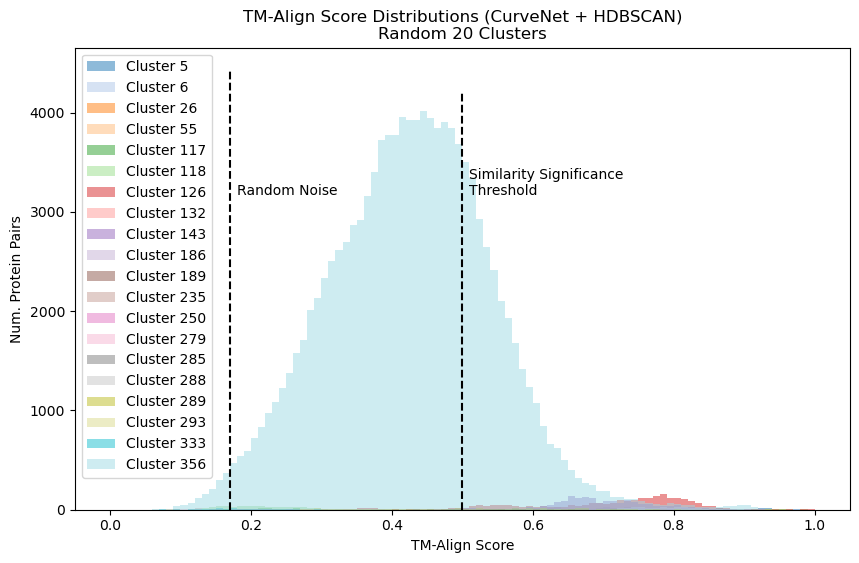

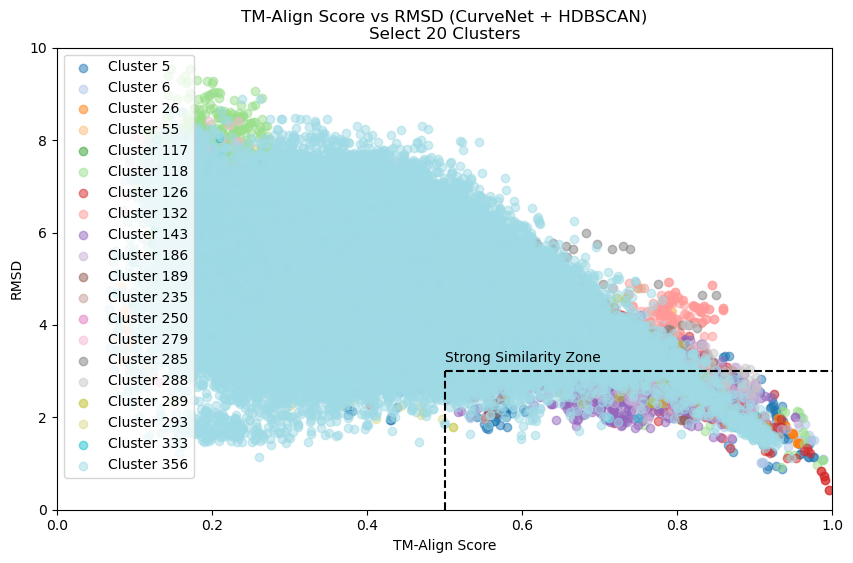

In [261]:
from utils import model_and_evaluate_cluster as ev

cmap = 'tab20'
plot_1_clusters = ev.tmalign_hist(model_stats, version='random', num_results=20, cmap=cmap, name=name)
plot_2_clusters = ev.tmalign_scatter(model_stats[model_stats.cluster.isin(plot_1_clusters)], cmap=cmap, name=name)

In [ ]:
# TODO: handle clusters with no scores
# BUT ALSO: I don't think this is a very relevant or even correct test. Can and should probably be ignored.
# import scipy.stats as st

# tmalign_stats_agg = pd.DataFrame(None, columns=['cluster', 'cl', 'ci', 'spread'])
# alpha = 0.98

# for cluster in model_stats.cluster.unique():
#     data = model_stats[(~model_stats.tmalign_score.isna()) & (model_stats.cluster == cluster)]
#     ci = st.norm.interval(alpha=alpha, loc=np.mean(data.tmalign_score.values), scale=st.sem(data.tmalign_score.values))
#     tmalign_stats_agg.loc[len(tmalign_stats_agg.index)] = [cluster, alpha, ci, ci[1] - ci[0]]
# print(f'{name}: Num. Clusters by Confidence Interval Spread\n{len(tmalign_stats_agg)} Clusters Evaluated')
# tmalign_stats_agg.spread.hist(bins=25);

# Add BLAST Stats & Explore

In [310]:
blast = pd.read_parquet('blast_annotations_agg.parquet')
blast.set_index(['query_protein', 'target_protein'], inplace=True)
model_stats_expanded = model_stats.set_index(['query_protein', 'target_protein']).join(blast, on=['query_protein', 'target_protein'], how='left')
model_stats_expanded

cluster  query_protein_length  \
query_protein         target_protein                                         
AF-Q92851-F1-model_v1 AF-Q99538-F1-model_v1        0                 521.0   
                      AF-P49662-F1-model_v1        0                 521.0   
                      AF-O15519-F1-model_v1        0                 521.0   
                      AF-Q14790-F1-model_v1        0                 521.0   
                      AF-P55211-F1-model_v1        0                 521.0   
...                                              ...                   ...   
AF-Q15916-F1-model_v1 AF-Q8NCN2-F1-model_v1      357                   NaN   
                      AF-Q9NPC7-F1-model_v1      357                   NaN   
                      AF-P10074-F1-model_v1      357                   NaN   
                      AF-O15060-F1-model_v1      357                   NaN   
                      AF-P24278-F1-model_v1      357                   NaN   

                                             target_protein_length  \
query_protein         target_protein                                 
AF-Q92851-F1-model_v1 AF-Q99538-F1-model_v1                  433.0   
                      AF-P49662-F1-model_v1                  377.0   
                      AF-O15519-F1-model_v1                  480.0   
                      AF-Q14790-F1-model_v1                  479.0   
                      AF-P55211-F1-model_v1                  416.0   
...                                                            ...   
AF-Q15916-F1-model_v1 AF-Q8NCN2-F1-model_v1                    NaN   
                      AF-Q9NPC7-F1-model_v1                    NaN   
                      AF-P10074-F1-model_v1                    NaN   
                      AF-O15060-F1-model_v1                    NaN   
                      AF-P24278-F1-model_v1                    NaN   

                                             aligned_length  rmsd  \
query_protein         target_protein                                
AF-Q92851-F1-model_v1 AF-Q99538-F1-model_v1           182.0  4.11   
                      AF-P49662-F1-model_v1           250.0  4.28   
                      AF-O15519-F1-model_v1           191.0  3.11   
                      AF-Q14790-F1-model_v1           248.0  4.43   
                      AF-P55211-F1-model_v1           215.0  3.81   
...                                                     ...   ...   
AF-Q15916-F1-model_v1 AF-Q8NCN2-F1-model_v1             NaN   NaN   
                      AF-Q9NPC7-F1-model_v1             NaN   NaN   
                      AF-P10074-F1-model_v1             NaN   NaN   
                      AF-O15060-F1-model_v1             NaN   NaN   
                      AF-P24278-F1-model_v1             NaN   NaN   

                                             tmalign_score  hit_span_mean  \
query_protein         target_protein                                        
AF-Q92851-F1-model_v1 AF-Q99538-F1-model_v1        0.30039            NaN   
                      AF-P49662-F1-model_v1        0.41562     221.000000   
                      AF-O15519-F1-model_v1        0.33610     440.000000   
                      AF-Q14790-F1-model_v1        0.41147     435.000000   
                      AF-P55211-F1-model_v1        0.37304     216.000000   
...                                                    ...            ...   
AF-Q15916-F1-model_v1 AF-Q8NCN2-F1-model_v1            NaN     157.250000   
                      AF-Q9NPC7-F1-model_v1            NaN     114.250000   
                      AF-P10074-F1-model_v1            NaN     155.000000   
                      AF-O15060-F1-model_v1            NaN     147.333333   
                      AF-P24278-F1-model_v1            NaN      53.500000   

                                             bitscore_mean   evalue_mean  
query_protein         target_protein                                      
AF-Q92851-F1-model_v1 AF-Q99538-F1-model_v1            NaN           

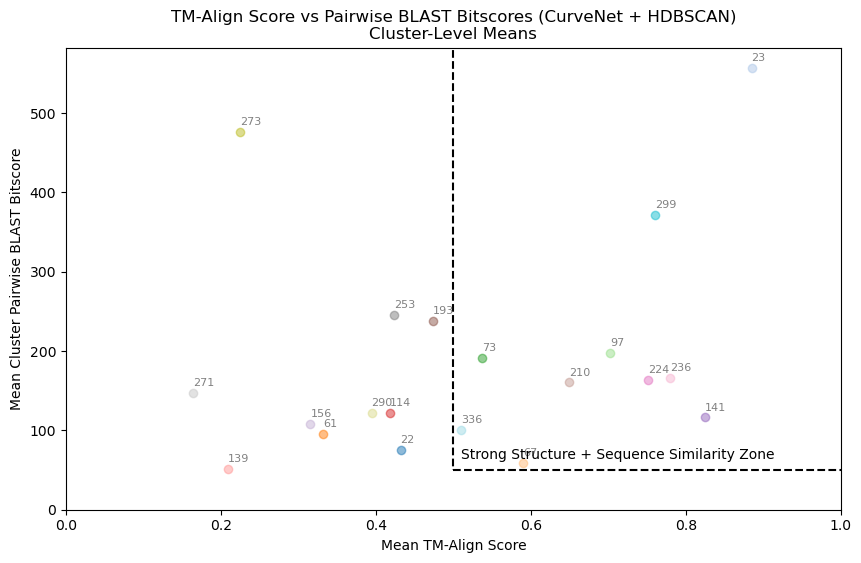

In [311]:
from matplotlib import pyplot
from matplotlib.pyplot import figure

t = model_stats_expanded[~model_stats_expanded.rmsd.isna() & ~model_stats_expanded.bitscore_mean.isna()][['cluster', 'tmalign_score', 'bitscore_mean']].groupby(['cluster']).mean().reset_index()
t = t[t.cluster.isin(t.cluster.sample(20))]

cmap='tab20'
figure(figsize=(10, 6))
pyplot.style.use('default')
colors = pyplot.get_cmap(cmap, len(t))

for i, cluster in enumerate(t.values):
    pyplot.scatter(x=cluster[1], y=cluster[2], alpha=0.5, color=colors(i), label=f'Cluster {int(cluster[0])}')
    pyplot.annotate(int(cluster[0]), # this is the text
                 (cluster[1],cluster[2]), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='left',
                   fontsize=8., color='grey') # horizontal alignment can be left, right or center
#pyplot.legend(loc='upper left')

pyplot.xlim(left=0, right=1)
pyplot.ylim(bottom=0)
pyplot.vlines(0.5, t.bitscore_mean.max() +50, 50, linestyles='dashed', colors='k')
pyplot.hlines(50, 0.5, 1, linestyles='dashed', colors='k')
pyplot.text(0.51, 64, 'Strong Structure + Sequence Similarity Zone')
pyplot.xlabel('Mean TM-Align Score')
pyplot.ylabel('Mean Cluster Pairwise BLAST Bitscore')
pyplot.title(f'TM-Align Score vs Pairwise BLAST Bitscores ({name})\nCluster-Level Means')
pyplot.show();

In [313]:
model_stats_expanded.hit_span_mean = model_stats_expanded.hit_span_mean.fillna(0)
model_stats_expanded.bitscore_mean = model_stats_expanded.bitscore_mean.fillna(0)
model_stats_expanded.evalue_mean = model_stats_expanded.evalue_mean.fillna(0)

t = model_stats_expanded[~model_stats_expanded.rmsd.isna()][['cluster', 'tmalign_score', 'bitscore_mean', 'rmsd']].groupby(['cluster']).mean().reset_index()
z = t[t.bitscore_mean > 50]
z = z[z.tmalign_score > 0.5]
z = z[z.rmsd < 3.]
print(name.upper())
print(f'Percent clusters in S4 Zone intersect S2 Zone:', round(len(z) / len(t), 4))
tmp = model_stats_expanded[~model_stats_expanded.rmsd.isna()]
print(f'Percent protein pairs in S4 Zone intersect S2 Zone:', round(len(tmp[tmp.cluster.isin(z.cluster.unique())]) / len(tmp), 4))
print('Noise Ratio:', round(len(model_stats_expanded[model_stats_expanded.cluster == -1]) / len(model_stats_expanded[~model_stats_expanded.tmalign_score.isna()]), 4), '(should be 0; noise pre-trimmed)')
print('TM-Align score coverage:', round(len(model_stats_expanded[~model_stats_expanded.rmsd.isna()]) / len(model_stats_expanded), 4))

CURVENET + HDBSCAN
Percent clusters in S4 Zone intersect S2 Zone: 0.1821
Percent protein pairs in S4 Zone intersect S2 Zone: 0.3553
Noise Ratio: 0.0 (should be 0; noise pre-trimmed)
TM-Align score coverage: 0.5506


## Experiment-Level Metrics

**S2** represents the Strong Similarity zone, where TM-Align > 0.5 and RMSD < 3.

**S4** represents the Strong Structure + Sequence Similarity zone, where TM-Align > 0.5 and Bitscore > 50.

|Pct. S4 $\bigcap$ S2|SeqVec + DBSCAN|SeqVec + HDBSCAN|DeepFold + DBSCAN|DeepFold + HDBSCAN|
|--------------------|           ---:|            ---:|             ---:|              ---:|
|Clusters            |      **0.436**|          0.3419|           0.2051|            0.1538|
|Protein Pairs       |     **0.6263**|          0.3806|           0.0009|            0.0578|
|Noise Ratio         |            0.0|             0.0|              0.0|               0.0|
|TM-Align Coverage   |           0.42|          0.7186|           0.0045|             0.306|

**Questions**
1. Is the noise ration 0.0 for SeqVec + HDBSCAN and DeepFold + DBSCAN because the data already excludes the noise cluster? Is the noise cluster always -1 for all models?

**Insights**
1. We can stop mining DeepFold + DBSCAN pairs. TM-Align Coverage is almost 100% and other metrics are terrible. DeepFold + HDBSCAN Coverage is the lowest of the bunch, however even so the metrics are so much lower than the SeqVec models, we should probably just focus additional TM-Align runs on SeqVec models. Right now between the two of those, we have very similar Coverage and while the % clusters in S4 $\bigcap$ S2 is 9% higher in the DBSCAN model, the proportion of Protein Pairs is marginally higher in HDBSCAN. Thus it may make sense to increase coverage for both to see if the metrics start to favor just one, or continue to diverge, indicating 2 possible solid choices. See caveat re: Noise Ratio for these 2 models above.

In [314]:
import pickle
import math

#download_file(file_noise)
download_file(file_cluster)

# with open(file_noise.split('/')[2], 'rb') as f:
#     data = pickle.load(f)
# print(data)
    
c = pd.read_parquet(file_cluster.split('/')[2]).reset_index()

total_proteins = c.num_proteins.sum()
noise_proteins = c[c.cluster_label == -1].num_proteins.sum()
clustered_proteins = total_proteins - noise_proteins

# Now just focus on non-noise (i.e. clustered) proteins
c = c[c.cluster_label != -1]

num_clusters = len(c.cluster_label.unique())

# Distribution is very left-skewed, even after log-transform. So instead of taking mean + std dev we'll use the 1st and 3rd quantiles to articulate spread.

# breaks when super skewed with many values the same
#quantiles = pd.qcut(c.num_proteins, q=3, retbins=True, duplicates='drop')[1]
#proteins_within_ntile = c[c.num_proteins <= quantiles[2]].num_proteins.sum()

# use this intead; collapses repeated values across bins into 1
def pct_rank_qcut(series, n):
    edges = pd.Series([float(i) / n for i in range(n + 1)])
    f = lambda x: (edges >= x).values.argmax()
    return series.rank(pct=1).apply(f)

proteins_within_ntile = c[pct_rank_qcut(c.num_proteins, n=4).isin([1, 2, 3])].num_proteins.sum()

print(f'Experiment Summary ({name.upper()})\n')

print(f'Proteins: {total_proteins:,.0f}')
print(f'Noise: {noise_proteins:,.0f} ({round(noise_proteins / total_proteins, 4)})')
print(f'Remaining Clustered Proteins: {clustered_proteins:,.0f} ({round(clustered_proteins / total_proteins, 4)})')
print(f'Remaining Clusters: {num_clusters:,.0f}')

print('\nNow, just focusing on clustered proteins (i.e. excluding noise):')

print('\nHow evenly distributed are the clusters? If more normal or uniform,\n'
      'most proteins should fall WITHIN the 3rd quartile. The greater the skew\n' 
      '(wildly disproportionately sized clusters), the more proteins we should\n'
      'expect to see OUTSIDE the 3rd quartile.')
print(f' - Num. Proteins WITHIN 3rd Quartile: {proteins_within_ntile:,.0f} ({round(proteins_within_ntile / clustered_proteins, 4)})')
print(f' - Num. Proteins OUTSIDE 3rd Quartile: {clustered_proteins - proteins_within_ntile:,.0f} ({round((clustered_proteins - proteins_within_ntile) / clustered_proteins, 4)})')

# Now just focus on proteins with annotations
k = model_stats_expanded.reset_index()

k = k[['query_protein', 'tmalign_score', 'bitscore_mean']].groupby(['query_protein']).count() > 1
k = k.reset_index()
mask = (k.tmalign_score == True) & (k.bitscore_mean == True)
proteins_with_pairwise_stats = len(k[mask].query_protein)
proteins_without_praiwise_stats = len(k) - proteins_with_pairwise_stats

# NO - need to know numof pairs and then pairs with annotations (just like above); makes sense to pivot from proteins to pairs at this point
# also logic is wrong. NULL bitscore is equal to 0, so we shuldn't be filtering on that criteria as indicating we have no blast. we do. its just 0. i.e. we should only filte rout null tmalign scores. but maybe fill null blast with 0s
print(f'\nProteins WITH Annotations: {proteins_with_pairwise_stats:,.0f} ({round(proteins_with_pairwise_stats / clustered_proteins, 4)})')
#print('Num. Proteins (Y) by Cluster Label (X):')
#c.plot(x='cluster_label', y='num_proteins', legend=False, xlabel='', figsize=(3,2));

Experiment Summary (CURVENET + HDBSCAN)

Proteins: 19,442
Noise: 9,556 (0.4915)
Remaining Clustered Proteins: 9,886 (0.5085)
Remaining Clusters: 358

Now, just focusing on clustered proteins (i.e. excluding noise):

How evenly distributed are the clusters? If more normal or uniform,
most proteins should fall WITHIN the 3rd quartile. The greater the skew
(wildly disproportionately sized clusters), the more proteins we should
expect to see OUTSIDE the 3rd quartile.
 - Num. Proteins WITHIN 3rd Quartile: 4,388 (0.4439)
 - Num. Proteins OUTSIDE 3rd Quartile: 5,498 (0.5561)

Proteins WITH Annotations: 9,791 (0.9904)


# Explore OPTICS In-Progress Models

In [233]:
def preview_results():
    experiments = ['DeepFold-UnMasked-NoLowConf_OPTICS_gridsearch']

    gs_results = pd.DataFrame(None, columns = ['metric', 'min_samples', 'proteins', 'runtime', 'noise', 'clusters_no_noise', 'silhouette_no_noise', 'cluster_sizes_no_noise', 'experiment', 'noise_ratio'])
    for exp in experiments:
        t = pd.read_parquet(exp + '.parquet')
        t['experiment'] = exp
        t['noise_ratio'] = round(t.noise / t.proteins, 2)
        gs_results = gs_results.append(t)

    return gs_results.sort_values(by=['clusters_no_noise', 'silhouette_no_noise'], ascending=False)

t = preview_results()
t

,metric,min_samples,proteins,runtime,noise,clusters_no_noise,silhouette_no_noise,cluster_sizes_no_noise,experiment,noise_ratio
3,l1,2,19320,42,10958,3229,0.802819,"[10, 9, 9, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6...",DeepFold-UnMasked-NoLowConf_OPTICS_gridsearch,0.57
0,euclidean,2,19320,44,11059,3167,0.789624,"[13, 9, 9, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7...",DeepFold-UnMasked-NoLowConf_OPTICS_gridsearch,0.57
6,l2,2,19320,44,11059,3167,0.789624,"[13, 9, 9, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7...",DeepFold-UnMasked-NoLowConf_OPTICS_gridsearch,0.57
4,l1,3,19320,45,14508,1102,0.858362,"[17, 16, 16, 16, 15, 14, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 10,...",DeepFold-UnMasked-NoLowConf_OPTICS_gridsearch,0.75
1,euclidean,3,19320,43,14645,1095,0.833553,"[16, 15, 14, 13, 13, 13, 13, 13, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10,...",DeepFold-UnMasked-NoLowConf_OPTICS_gridsearch,0.76
7,l2,3,19320,83,14645,1095,0.833553,"[16, 15, 14, 13, 13, 13, 13, 13, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10,...",DeepFold-UnMasked-NoLowConf_OPTICS_gridsearch,0.76
5,l1,4,19320,40,16025,524,0.834968,"[25, 20, 20, 18, 18, 17, 17, 16, 16, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 14, 13, 13, 13,...",DeepFold-UnMasked-NoLowConf_OPTICS_gridsearch,0.83
2,euclidean,4,19320,43,16101,521,0.811827,"[20, 20, 19, 19, 18, 17, 17, 16, 16, 15, 15, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 12,...",DeepFold-UnMasked-NoLowConf_OPTICS_gridsearch,0.83
8,l2,4,19320,90,16101,521,0.811827,"[20, 20, 19, 19, 18, 17, 17, 16, 16, 15, 15, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 12,...",DeepFold-UnMasked-NoLowConf_OPTICS_gridsearch,0.83


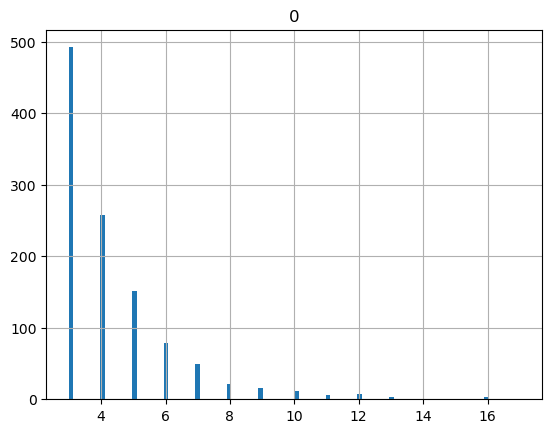

In [209]:
pd.DataFrame(t.iloc[2].cluster_sizes_no_noise).hist(bins=100);

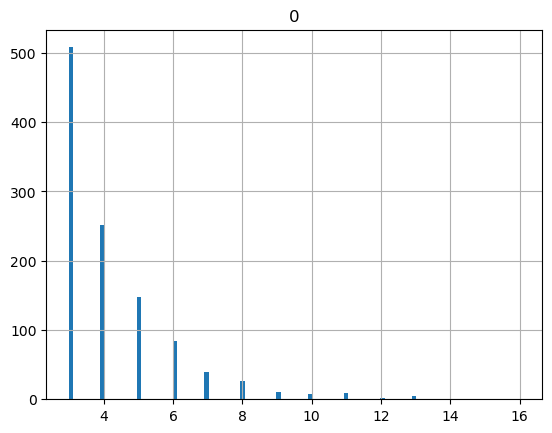

In [210]:
pd.DataFrame(t.iloc[3].cluster_sizes_no_noise).hist(bins=100);

# Produce Combos File from Labels File

In [ ]:
'DeepFold-UnMasked-NoLowConf_OPTICS_gridsearch_l1_2_labels.parquet'

# Find all combinations of proteins WITHIN clusters
all_combos = pd.DataFrame()

for clust in list(set(clustering.labels_[clustering.labels_ != -1])):
    clust_combos = pd.DataFrame(itertools.product(data[data.cluster == clust].protein, repeat=2), columns=['query_protein', 'target_protein'])
    clust_combos = clust_combos[clust_combos.query_protein != clust_combos.target_protein]
    clust_combos['cluster'] = clust
    all_combos = all_combos.append(clust_combos)

print(len(all_combos))
all_combos[['cluster', 'query_protein']].groupby(['cluster']).count().reset_index().query_protein.hist();

In [235]:
pd.read_parquet('B1EP-HDBSCAN-DeepFold_EP-all_protein_combos_per_cluster.parquet')

,query_protein,target_protein,cluster
1,Q9UHF0,P07741,0
2,Q9UHF0,P33076,0
3,Q9UHF0,Q9NXC2,0
4,Q9UHF0,P17405,0
5,Q9UHF0,Q8IV08,0
...,...,...,...
250,Q8NH76,P08913,556
251,Q8NH76,Q96PG2,556
252,Q8NH76,Q9UIV1,556
253,Q8NH76,Q5VUJ6,556


In [236]:
pd.read_parquet('DeepFold-UnMasked-NoLowConf_OPTICS_gridsearch_l1_2_labels.parquet')

,label
0,-1
1,-1
2,-1
3,257
4,2163
...,...
19315,-1
19316,182
19317,-1
19318,-1
